1- Import XRay Images


In [3]:
import os 
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os


# Analyse du dataset

Le dataset est composé d'images de radiographies thoraciques. Le dataset est déjà divisé en train, val et test. Les images sont classées en NORMAL et PNEUMONIA. Les images de radiographies thoraciques sont en niveaux de gris.

Le problème est donc un problème de classification binaire. L'objectif est de prédire si une personne est atteinte de pneumonie ou non.

Nous commençons par définir des fonctions utilitaires pour parcourir et afficher les images. Ça nous sera utile pour analyser les données et comprendre les caractéristiques des images.

In [4]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img)
                
                
def display_imgs(imgs, titles = None, plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [6]:
folders_infos = {}
current_folder = None
def get_folders_infos_callback(folder_path, images_files):
    global folders_infos, current_folder
    folders_infos[folder_path] = []
    current_folder = folder_path
    
def add_imgs_size_to_folders_infos_callback(img):
    folders_infos[current_folder].append(img.shape)

browse_imgs(add_imgs_size_to_folders_infos_callback, get_folders_infos_callback, limit_size=5)

for folder_path, imgs_sizes in folders_infos.items():
    print("tailles des premières images du dossier {} : {}".format(folder_path, imgs_sizes) )

tailles des premières images du dossier ./chest_Xray/train/NORMAL : [(1279, 1670), (1129, 1574), (1391, 1646), (1670, 1820), (1102, 1338)]
tailles des premières images du dossier ./chest_Xray/train/PNEUMONIA : [(560, 936), (1447, 1841), (928, 1352), (632, 1016), (688, 952)]
tailles des premières images du dossier ./chest_Xray/val/NORMAL : [(1416, 1736), (1225, 1632), (1040, 1272), (928, 1288), (1302, 1564)]
tailles des premières images du dossier ./chest_Xray/val/PNEUMONIA : [(592, 968), (712, 1072), (864, 1256), (664, 1152), (944, 1416)]
tailles des premières images du dossier ./chest_Xray/test/NORMAL : [(1357, 1890), (1504, 1741), (1326, 1862), (912, 1392), (1953, 2170)]
tailles des premières images du dossier ./chest_Xray/test/PNEUMONIA : [(640, 832), (560, 952), (936, 1216), (1144, 1592), (648, 1032)]


On constate que les radios sont de tailles différentes. L'uniformisation des données est une étape importante du prétraitement des données. Il faudra donc les redimensionner pour les passer en entrée d'un modèle de machine learning.

Analysons plus en détail l'hétérogénéité du dataset.

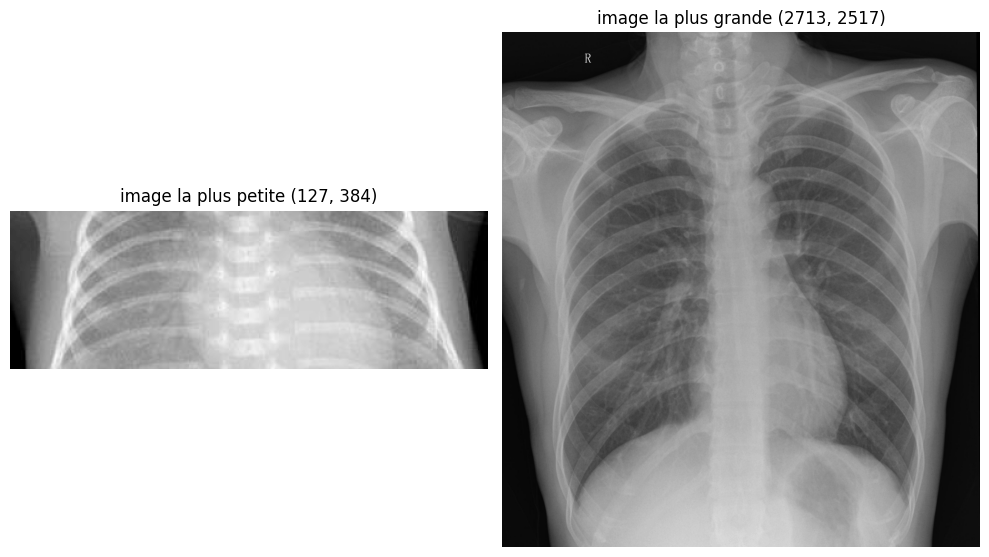

In [5]:
smallest_img = None
largest_img = None

def search_size_callback(img):
    global smallest_img, largest_img
    largest_img_size = largest_img.shape if largest_img is not None else None
    smallest_img_size = smallest_img.shape if smallest_img is not None else None
    img_size = img.shape
    if largest_img_size is None or img_size > largest_img_size:
        largest_img = img
    if smallest_img_size is None or img_size < smallest_img_size:
        smallest_img = img
 
browse_imgs(search_size_callback)               
                    
display_imgs([smallest_img, largest_img], ["image la plus petite {}".format(smallest_img.shape), "image la plus grande {}".format(largest_img.shape)], (1,2))

In [7]:
def sort_image(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [6]:
counter = 0
sorted_imgs = {1.1:[], 1.2:[], 1.3:[], 1.5:[], 1.6:[], 2:[]}

def sort_img_callback(img):
    global counter, sorted_imgs
    counter += 1
    for ratio_max, img_array in sorted_imgs.items():
        if sort_image(img, max_ratio=ratio_max):
            img_array.append(img)
            
browse_imgs(sort_img_callback)

print("Nombre d'images avant le prétraitement :", counter)
for ratio_t, img_array in sorted_imgs.items():
    print("Nombre d'images après le prétraitement pour un ratio {} : {}".format( ratio_t, len(img_array)))

Nombre d'images avant le prétraitement : 5856
Nombre d'images après le prétraitement pour un ratio 1.1 : 238
Nombre d'images après le prétraitement pour un ratio 1.2 : 849
Nombre d'images après le prétraitement pour un ratio 1.3 : 1757
Nombre d'images après le prétraitement pour un ratio 1.5 : 3672
Nombre d'images après le prétraitement pour un ratio 1.6 : 4431
Nombre d'images après le prétraitement pour un ratio 2 : 5668


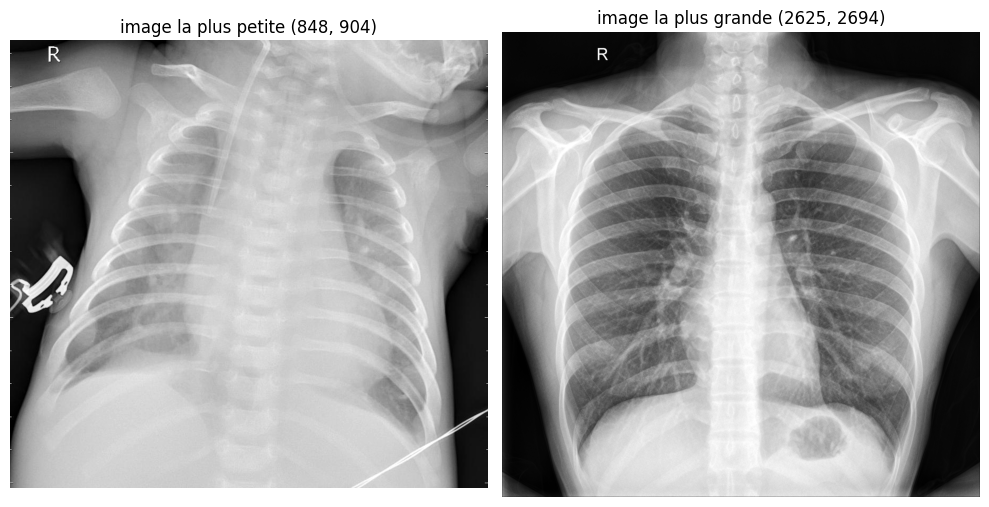

In [7]:
smallest_img = None
largest_img = None
for img in sorted_imgs[1.1]:
    if img is not None:
        search_size_callback(img)

display_imgs([smallest_img, largest_img], ["image la plus petite {}".format(smallest_img.shape), "image la plus grande {}".format(largest_img.shape)], (1,2))

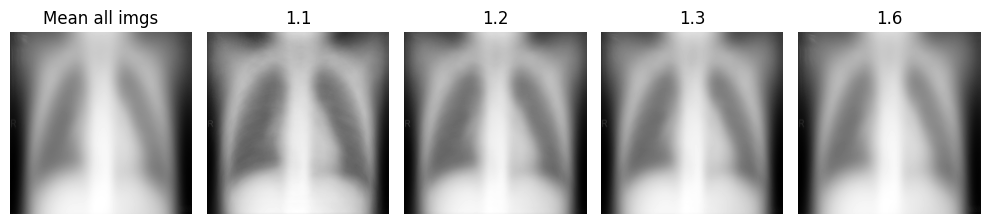

In [8]:
all_imgs = []
sorted_imgs = {1.1:[], 1.2:[], 1.3:[], 1.6:[]}

def collect_imgs_callback(img):
    global all_imgs
    for ratio_max, img_array in sorted_imgs.items():
        if sort_image(img, max_ratio=ratio_max):
            img_array.append(cv2.resize(img,(800,800)))
    img = cv2.resize(img,(800,800))
    all_imgs.append(img)
    
browse_imgs(collect_imgs_callback)

mean_images = [np.mean(all_imgs, axis=0)]
titles = ["Mean all imgs"]

for ratio_t, img_array in sorted_imgs.items():
    mean_images.append(np.mean(img_array, axis=0))
    titles.append(ratio_t)

display_imgs(mean_images, titles, plot_size=(1,len(mean_images)), figsize=(10,10))

2- Class XrayLoader

In [0]:
class XrayLoader:
    def __init__(self, data_folder, image_size):
        self.x_train = None
        self.y_train = None
        self.x_val = None
        self.y_val = None
        self.x_test = None
        self.y_test = None
        self.data_folder = data_folder
        self.image_size = image_size

    def load_data(self):
        subfolders = ["train","val","test"]
        categories = ["NORMAL","PNEUMONIA"]
        data = {}

        for subfolder in subfolders:
            data[subfolder] = {"x":[],"y":[]}
            for category in categories:
                # pour avoir tous les chemins des 6 dossiers
                folder_path = os.path.join(self.data_folder,subfolder,category)
                # liste de toutes les images
                images_files = os.listdir(folder_path)
                for file_name in images_files:
                    image_path = os.path.join(folder_path,file_name)
                    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,self.image_size)
                    data[subfolder]["x"].append(img)
                    data[subfolder]["y"].append(category)
                
        self.x_train = np.array(data["train"]["x"])
        self.y_train = data["train"]["y"]
        self.x_val = np.array(data["val"]["x"])
        self.y_val = data["val"]["y"]
        self.x_test = np.array(data["test"]["x"])
        self.y_test = data["test"]["y"]

    def display_image(self,dataset,index):
        if dataset == 'train':
            image = self.x_train[index]
            label = self.y_train[index]
            
        elif dataset == 'test':
            image = self.x_test[index]
            label = self.y_test[index]
        else:
            raise ValueError('Invalid dataset. Choose either "train" or "test".')

        plt.imshow(image,cmap="gray")
        plt.title(f'Image {index} - Catégorie: {label}')
        plt.axis('off')
        plt.show()
    
    def display_category_means(self):
        normal_mean = self.calculate_category_mean(self.x_train, self.y_train, "NORMAL")
        pneumonia_mean = self.calculate_category_mean(self.x_train, self.y_train, "PNEUMONIA")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(normal_mean, cmap="gray")
        plt.title("Mean NORMAL Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pneumonia_mean, cmap="gray")
        plt.title("Mean PNEUMONIA Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    @staticmethod
    def calculate_category_mean(images, labels, category):
        images = np.array(images)
        labels = np.array(labels)
        category_images = images[labels == category]
        mean_image = np.mean(category_images, axis=0)
        return mean_image
    
    def display_distribution(self):
        test = ( self.y_test.count("NORMAL"), self.y_test.count("PNEUMONIA") )
        train = ( self.y_train.count("NORMAL"), self.y_train.count("PNEUMONIA") )
        val = ( self.y_val.count("NORMAL"), self.y_val.count("PNEUMONIA") )
        
        # Tracer les graphiques de distribution
        fig, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].bar(["NORMAL", "PNEUMONIA"], train)
        ax[0].set_title("Train Distribution")
        ax[1].bar(["NORMAL", "PNEUMONIA"], val)
        ax[1].set_title("Validation Distribution")
        ax[2].bar(["NORMAL", "PNEUMONIA"], test)
        ax[2].set_title("Test Distribution")
        plt.show()
    


In [0]:
loader = XrayLoader(data_folder='./chest_Xray', image_size=(800, 800))
loader.load_data()
xtrain = loader.x_train
ytrain = loader.y_train
xtest = loader.x_test
ytest = loader.y_test
xval = loader.x_val
yval = loader.y_val

In [0]:
loader.display_image("train",5100)

In [0]:
loader.display_category_means()

In [0]:
loader.display_distribution()